# Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig105


# Flo's original approach
2. I design the states as "dimers", examplary run including the corresponding scripts can be found in `/home/flop/switch/5thround/DHRs/des_states6_np_all_flexbb/`

thus is the last round I did, nonpolar interface, flex bb, no selection before 
design. In earlier rounds I played around with polar interface design, 
fixedbb, only rigid body movement across the jump, keeping the bb fixed in one
of the two halves etc.

but I settled for the simple approach in des_states6

3. I then filtered the designed states using standard interface metrics. I made selections of different stringency, unfortunately IO did not save the exact criteria for the least stringent one that I ended up using

but I think it was probably something like interface_sc >= 0.65, score per res
<= -2.5, geometry == 1, and some kind of sasa/cms/ddG cutoff 
(or maybe not, i might hav ignored that one here)

# I will follow Flo's design procedure with some changes.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.
I'll use `beta_nov16` scorefunction.  
I'll try fixbb followed by flexbb design, and took out a lot of the filters I didn't think were informative.

# Make functions for design and scoring
Gonna put everything in one rosettascripts XML string  
No TRP allowed 

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *


@requires_init
def design_score(
    packed_pose_in: PackedPose, **kwargs
) -> Generator[PackedPose, PackedPose, None]:
    """Generator of PackedPose objects, does 2rds. of fixbb design followed by 3rds. of flexbb design."""
    import bz2
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        ppose = deepcopy(packed_pose_in)
        scores = deepcopy(packed_pose_in.pose.scores)
    if "sfxn" in kwargs:
        sfxn = kwargs["sfxn"]
    else:
        sfxn = "beta_nov16"
    # no TRP allowed in layer_design
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="{sfxn}" /> 
            <ScoreFunction name="sfxn_design" weights="{sfxn}" >
                <Reweight scoretype="res_type_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A"/>
            <Chain name="chB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chB" distance="8.0" />
            <Neighborhood name="interface_chB" selector="chA" distance="8.0" />
            <And name="interface_AB" selectors="interface_chA,interface_chB" />
            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
            <Or name="designable" selectors="interface_AB" />
            <Not name="not_designable" selector="designable" />
            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true"
                use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" 
                use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" 
                use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false"
                use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design">
                <Action selector_logic="surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="boundary AND helix_start" aas="ADEHIKLNPQRSTVY"/>
                <Action selector_logic="boundary AND helix"       aas="ADEHIKLNQRSTVYM"/>
                <Action selector_logic="boundary AND sheet"       aas="DEFHIKLNQRSTVY"/>
                <Action selector_logic="boundary AND loop"        aas="ADEFGHIKLNPQRSTVY"/>
                <Action selector_logic="core AND helix_start"     aas="AFILVYNQSTHP"/>
                <Action selector_logic="core AND helix"           aas="AFILVM"/>
                <Action selector_logic="core AND sheet"           aas="FILVY"/>
                <Action selector_logic="core AND loop"            aas="AFGILPVYSM"/>
                <Action selector_logic="helix_cap"                aas="DNSTP"/>
            </DesignRestrictions>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <ProteinProteinInterfaceUpweighter name="upweight_int" interface_weight="3" />
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <OperateOnResidueSubset name="int_only" selector="not_designable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
            <StructProfileMover name="gen_profile" add_csts_to_pose="1" consider_topN_frags="100" 
                eliminate_background="0" ignore_terminal_residue="1" only_loops="0"
                residue_selector="designable" burialWt="0" RMSthreshold="0.6" />
            <ClearConstraintsMover name="clear_constraints" />
            <FastDesign name="fixbb_with_jump" scorefxn="sfxn_design" repeats="1" 
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="false" />
                    <Chain number="2" chi="true" bb="false" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
            <FastDesign name="flexbb_with_jump" scorefxn="sfxn_design" repeats="2"
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                    <Chain number="2" chi="true" bb="true" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
            <SwitchChainOrder name="cutB" chain_order="1" />
            <SwitchChainOrder name="cutA" chain_order="2" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
        </MOVERS>
        <FILTERS>
            <Sasa name="interface_buried_sasa" confidence="0" />
            <SSShapeComplementarity name="sc" verbose="1" loops="1" helices="1" />
            <ShapeComplementarity name="sc_int" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <TaskAwareScoreType name="tot_score" scorefxn="sfxn" score_type="total_score" threshold="0" mode="total"  confidence="0" />
            <MoveBeforeFilter name="score_A" mover="cutB" filter="tot_score" confidence="0"/>
            <MoveBeforeFilter name="score_B" mover="cutA" filter="tot_score" confidence="0"/>
            <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <ResidueCount name="count" />
            <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                <Var name="total_score_full" filter="total_score_pose"/>
                <Var name="res" filter="count"/>
            </CalculatorFilter>
        </FILTERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add mover="gen_profile" />
            <Add mover="fixbb_with_jump" />
            <Add mover="flexbb_with_jump" />
            <Add mover="clear_constraints" />
            <Add filter_name="interface_buried_sasa" />
            <Add filter_name="sc" />
            <Add filter_name="sc_int" />
            <Add filter_name="score_A"/>
            <Add filter_name="score_B"/>
            <Add filter_name="score_per_res" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        sfxn=sfxn
    )
    design_score = SingleoutputRosettaScriptsTask(xml)
    designed_ppose = design_score(ppose.pose.clone())
    pose = io.to_pose(designed_ppose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "sfxn_used", sfxn)
    scores.update(dict(pose.scores))
    print(scores)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            pose, key, str(value)
        )  # store values as strings for safety
    designed_ppose = io.to_packed(pose)
    return designed_ppose

# Setup dask, set command line options, make tasks and submit to client
At some point I should try using `client.wait_for_workers(n_workers=1, timeout=None)`

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run one of the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}.ipd"
)

def create_tasks(selected, options):
    with open(selected, "r") as f:
        for file in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            tasks["sfxn"] = "beta_nov16"
            yield tasks

logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "01_make_states/selected_states.list")

options = { 
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
}

output_path = os.path.join(os.getcwd(), "02_design_score")

if __name__ == "__main__" :
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="8GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
        
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=5,
            ).distribute(protocols=[design_score])

run one of the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig105
ssh -L 8000:localhost:8787 pleung@dig105.ipd
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.135:38007 --nthreads 1 --memory-limit 7.45GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 55m --lifetime-stagger 4m

<Client: 'tcp://172.16.131.135:38007' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Look at scores
There is certainly a less embarrassing way to do this but at least this way is vectorized, so it should scale very well

In [5]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "02_design_and_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,bb_clash,ddg,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,...,sc,sc_int,scaffold,score,score_A,score_B,score_per_res,sfxn_used,shift,total_score
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.02.08.17.43.13.024236_a8002614e92d438b8772a373c0220771.pdb.bz2,11429.872070,-17.174719,0.0,-1392.958259,37.257296,160.201968,265.023974,-520.574017,-78.056721,-43.880595,...,0.742560,0.653548,DHR,0.0,-191.564117,-214.997482,-2.827511,beta_nov16,-4.0,-644.672576
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.02.08.17.43.13.024236_e0ff2a387bc1418898fd954ebce26a21.pdb.bz2,36.634998,-58.491993,0.0,-914.836579,22.035921,102.911150,188.269597,-327.534714,-58.159682,-37.383952,...,0.756012,0.770980,DHR,0.0,-134.781769,-132.979553,-2.984376,beta_nov16,3.0,-444.672091
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.02.08.17.43.13.024236_535406520e7e480cb25c989a0e849ac3.pdb.bz2,45.201000,-80.821800,0.0,-978.088165,29.929514,137.427422,160.754922,-347.000809,-51.146497,-46.602540,...,0.706989,0.757447,DHR,0.0,-87.233681,-96.719383,-2.588234,beta_nov16,0.0,-427.058625
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.02.08.17.43.13.024236_9ba0f2578cab413eab53d1ef57d57409.pdb.bz2,46.537998,-49.128475,0.0,-1045.227202,27.832570,125.827401,194.809269,-374.293507,-58.658965,-24.281653,...,0.781016,0.767362,DHR,0.0,-151.783356,-159.669205,-3.018019,beta_nov16,7.0,-507.027265
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.02.08.17.43.13.024236_6c66c6f00518406ab7b83ed6307f236e.pdb.bz2,50.632999,-54.654572,0.0,-1014.498600,24.786106,112.546103,207.916159,-373.045109,-66.093059,-42.898150,...,0.719053,0.798976,DHR,0.0,-130.325211,-140.390808,-2.864616,beta_nov16,4.0,-486.984669


In [6]:
len(scores_df)

5180

# Add reference states

In [7]:
output_path = os.path.join(os.getcwd(), "02_score_ref")
ref = os.path.join(output_path, "scores.json")
ref_df = read_scorefile(ref)
print(len(ref_df))
# sanity check
set(ref_df.columns)-set(scores_df.columns)

64


set()

# Analyze some scoreterms
Figure out a reasonable cutoff for filtering perhaps

In [8]:
scores_df.groupby(["scaffold"]).mean()

,bb_clash,ddg,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,...,rama_prepro,ref,sc,sc_int,score,score_A,score_B,score_per_res,shift,total_score
scaffold,,,,,,,,,,,,,,,,,,,,,
DHR,1633.523750,-74.519135,0.0,-1167.213399,31.981857,151.058658,222.850243,-420.814945,-70.092131,-40.792281,...,15.122514,-51.081467,0.723371,0.749881,0.0,-130.167532,-138.609682,-2.780497,0.099656,-527.972200
KH_DHR,2268.249233,-68.508368,0.0,-1146.376112,32.123052,136.753189,251.742211,-406.509925,-71.170726,-43.723711,...,23.543469,-36.691960,0.730281,0.738632,0.0,-128.513953,-125.847730,-2.665441,-0.020408,-501.578902
THR,1701.700752,-87.773669,0.0,-2175.299358,58.061957,266.604966,397.985964,-733.636528,-133.073541,-66.399925,...,84.620273,-66.040183,0.698485,0.743051,0.0,-277.489776,-282.148724,-2.864244,-0.035714,-972.681600
TH_DHR,866.913400,-94.180039,0.0,-1410.743285,35.120710,177.310786,255.228946,-505.153058,-81.916622,-51.845281,...,0.358613,-6.705548,0.730037,0.747721,0.0,-166.915321,-174.028762,-2.886533,-0.132597,-672.816496


# Group by parent scaffold then discard worst 10% of score/res, sasa, sc_int, ddg?
In this case, I think simply excluding the worst decoys should do the trick  
TODO maybe want to throw out the really high SASA?  
TODO I am excluding ddg for now as it has 0.96 correlation with SASA  
TODO 10% cutoff?

In [15]:
unique_parents = set(scores_df.parent.values)
scoreterms = ["interface_buried_sasa","sc","sc_int","score_per_res"]  
not_bad = []
for unique_parent in unique_parents:
    temp_df = scores_df[scores_df["parent"] == unique_parent]
    top_percentiles, bottom_percentiles = {}, {}
    for term in scoreterms: # get the 5th percentile of each term
        bottom_percentiles[term] = temp_df[term].quantile(0.10)
        top_percentiles[term] = temp_df[term].quantile(0.90)
    for index, row in temp_df.iterrows(): # make sure each row meets or exceeds the 5th percentile
        passed = True
        for term in scoreterms:
            if term != "score_per_res":
                if row[term] >= bottom_percentiles[term]:
                    pass
                else:
                    passed = False
                    break
            else: # score_per_res lower is better
                if row[term] <= top_percentiles[term]:
                    pass
                else:
                    passed = False
                    break
        if passed:
            not_bad.append(index)
            
not_bad_df = scores_df.query("index in @not_bad")            
len(not_bad_df)

3757

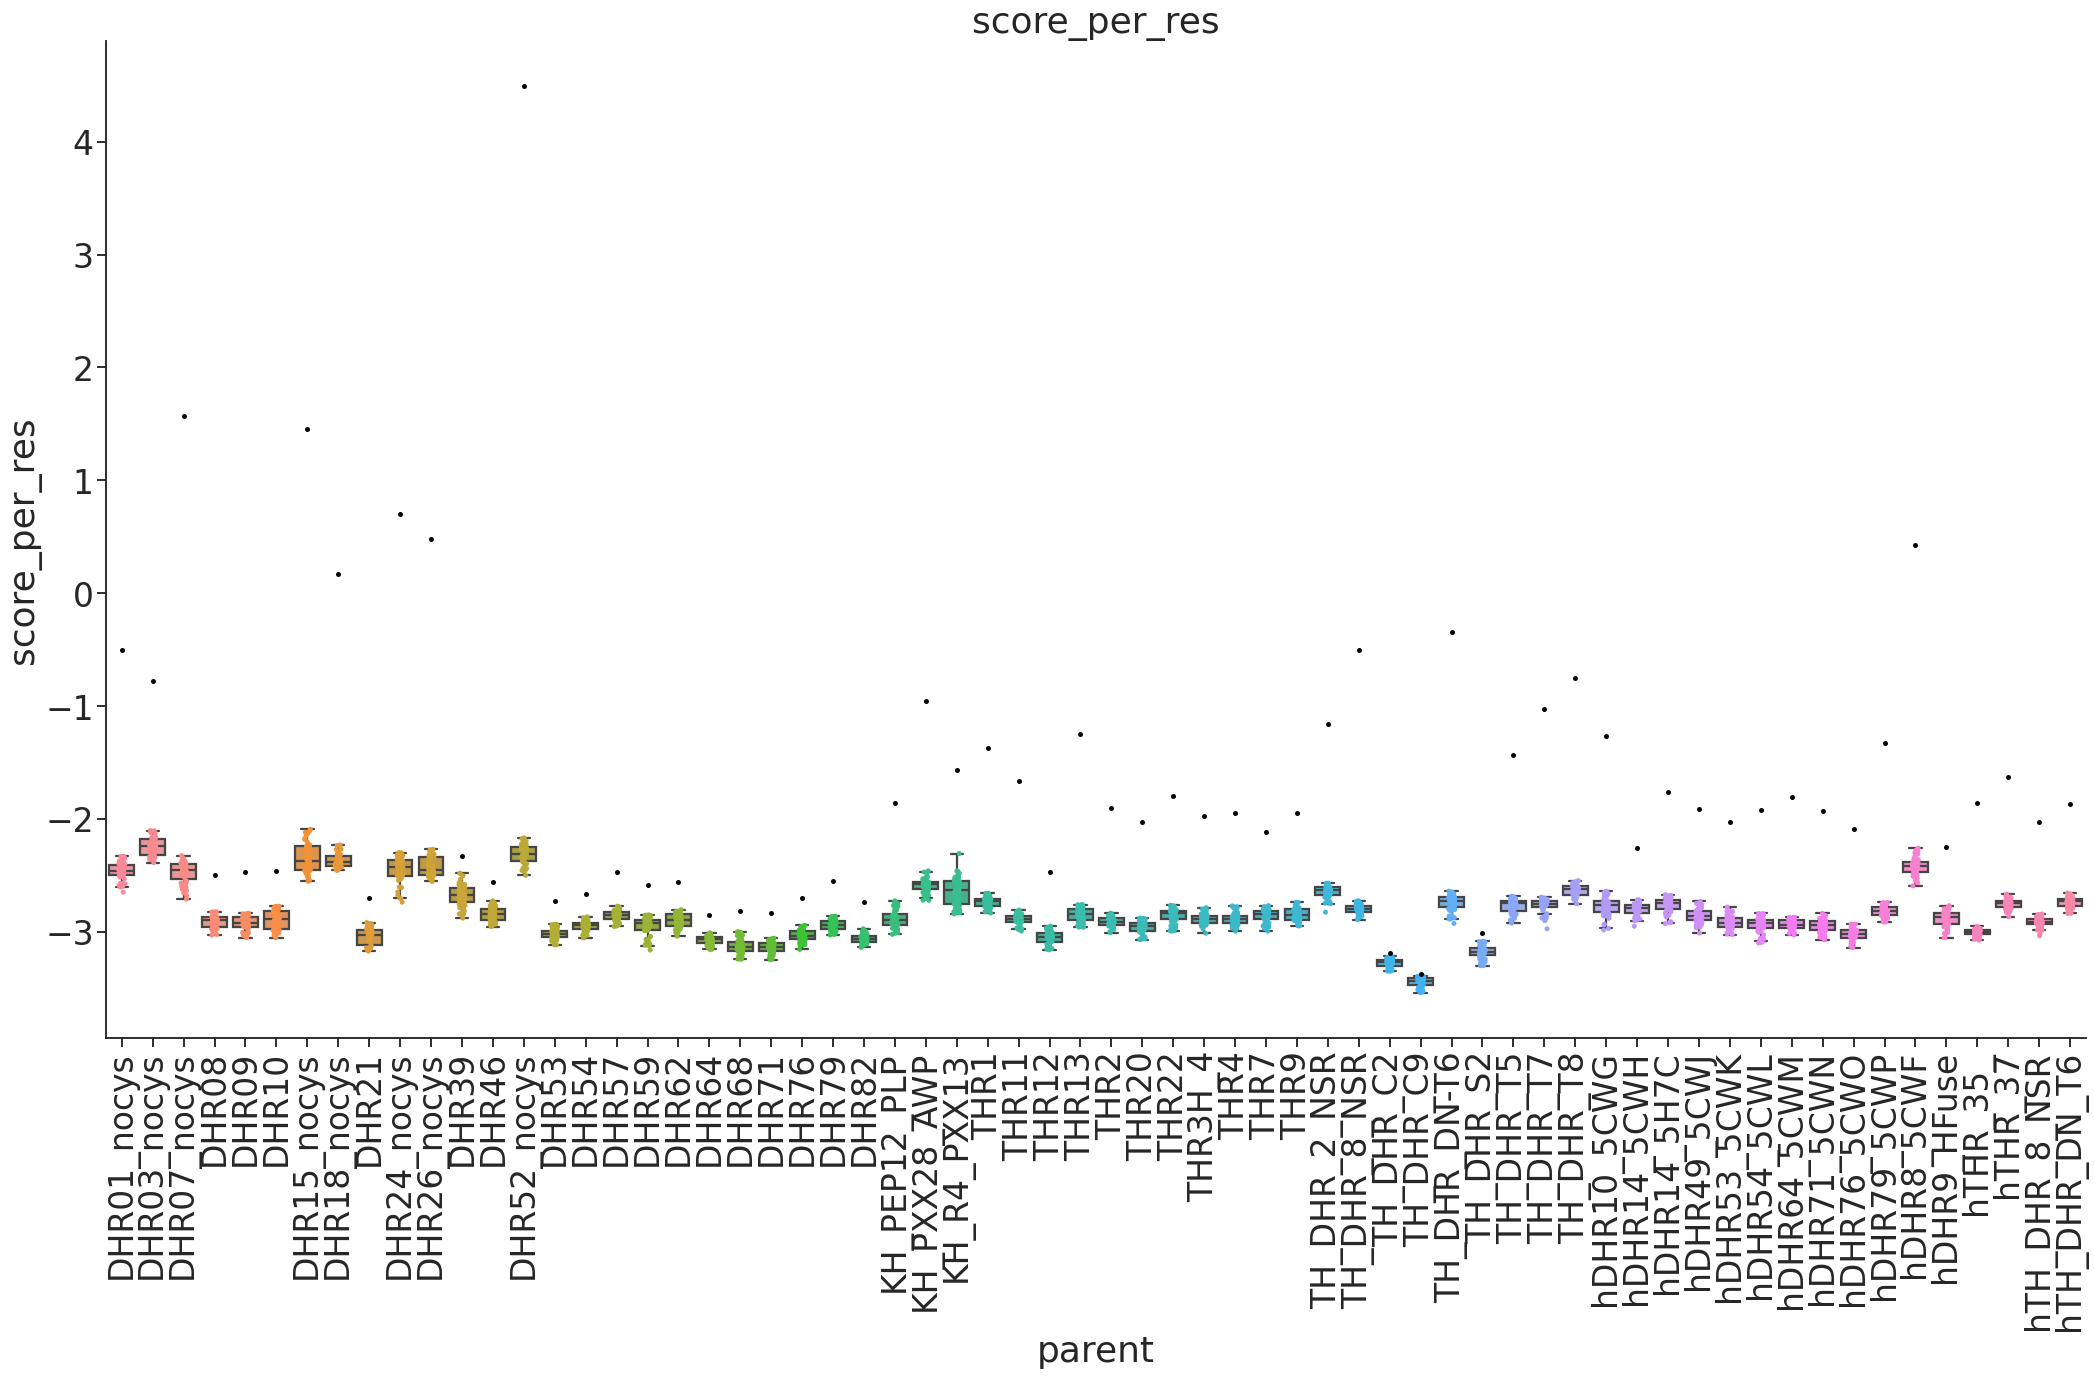

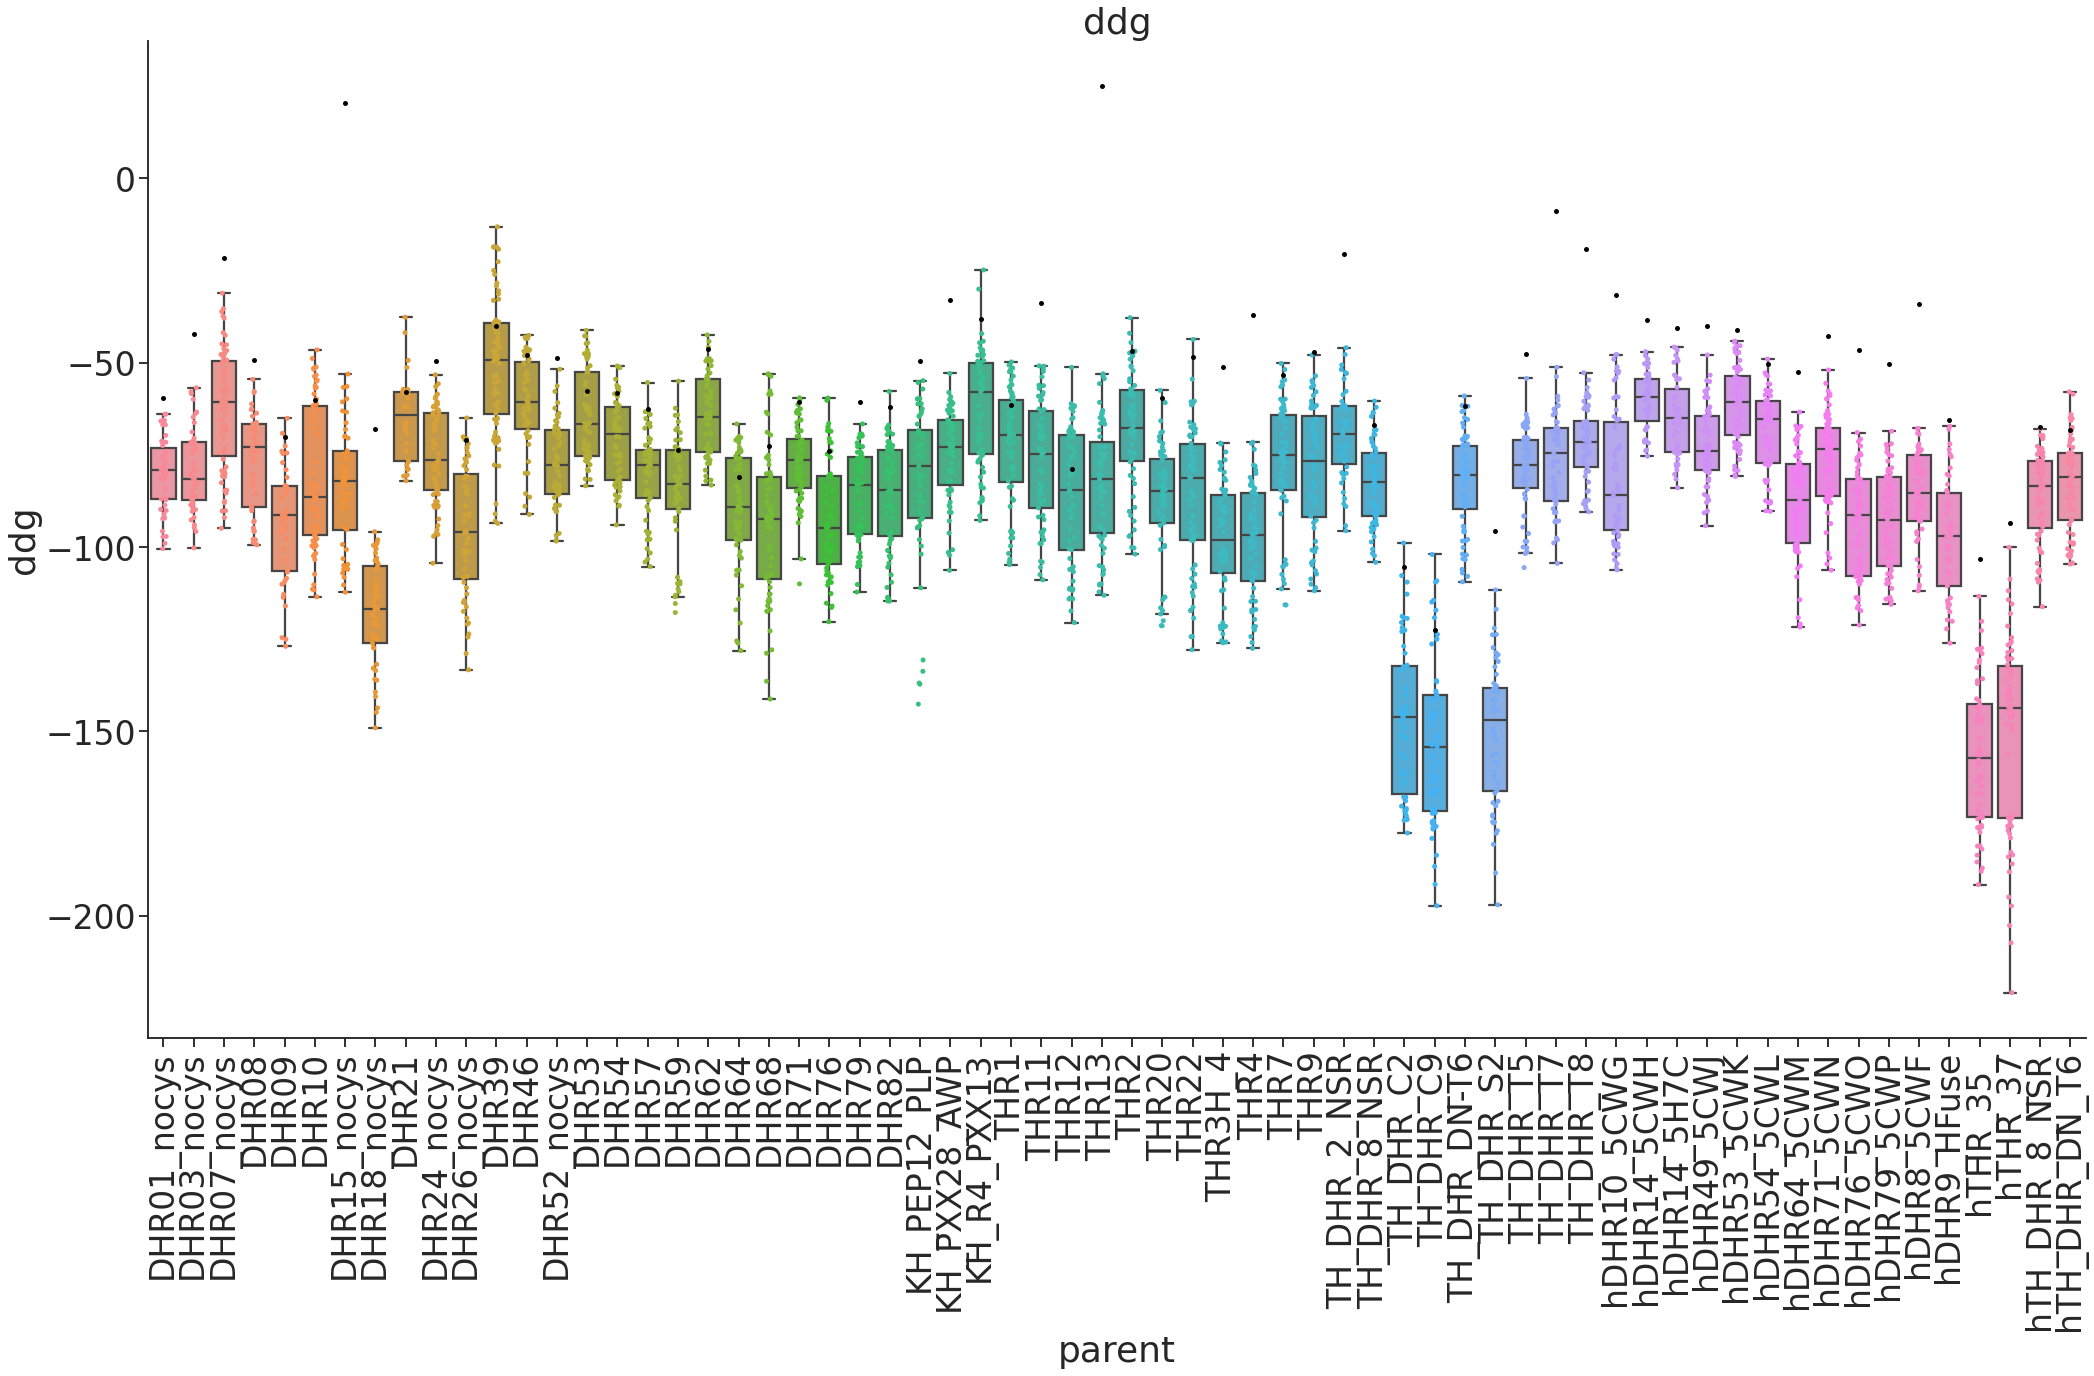

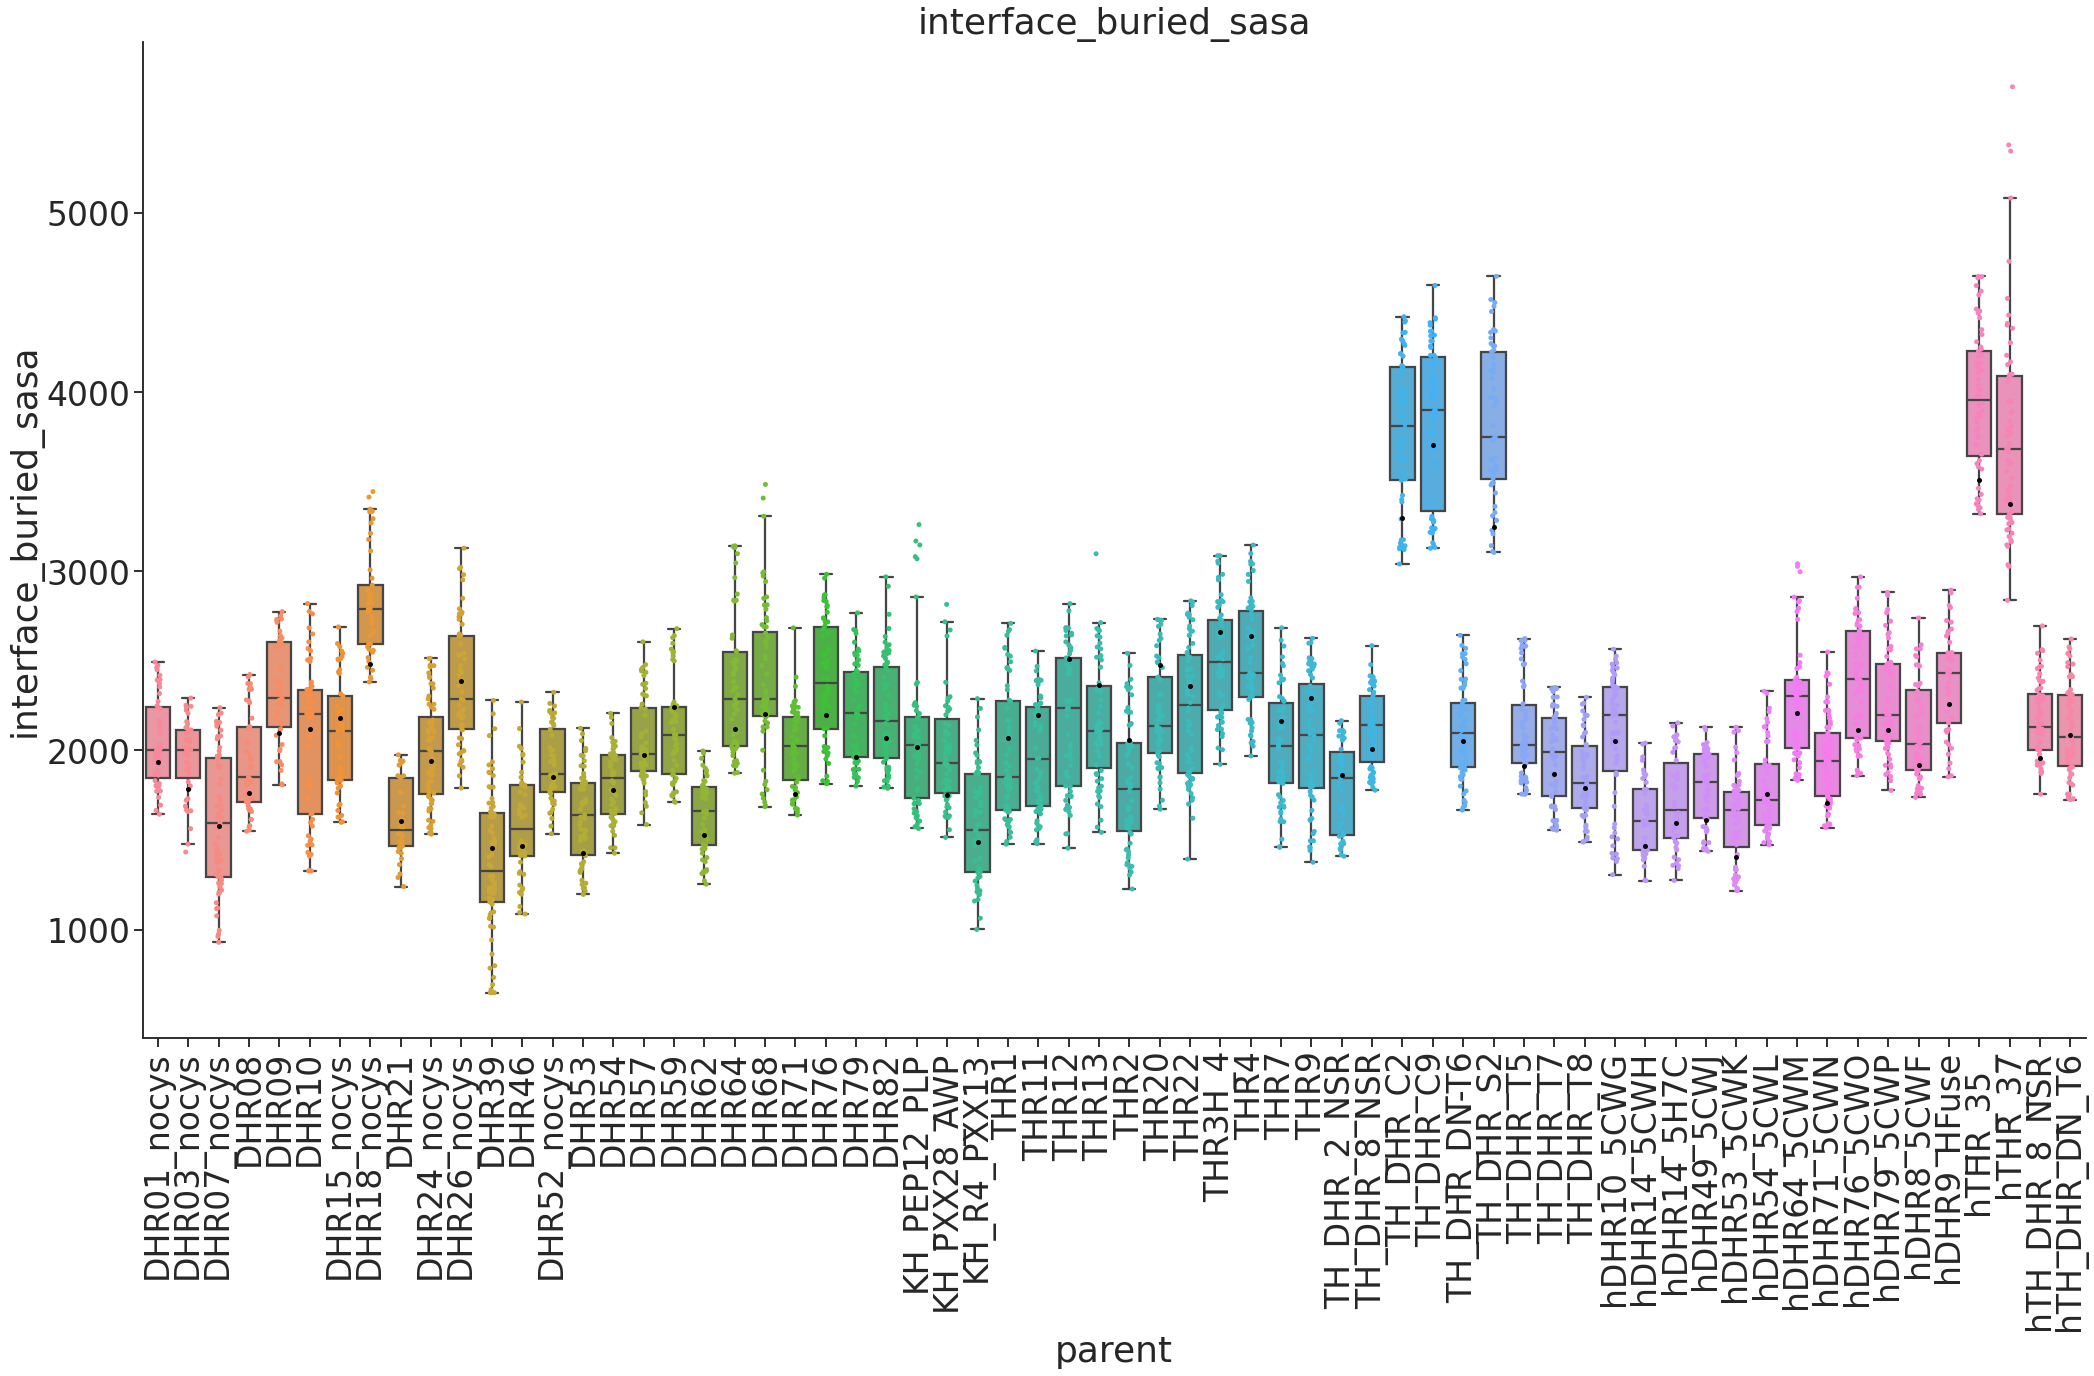

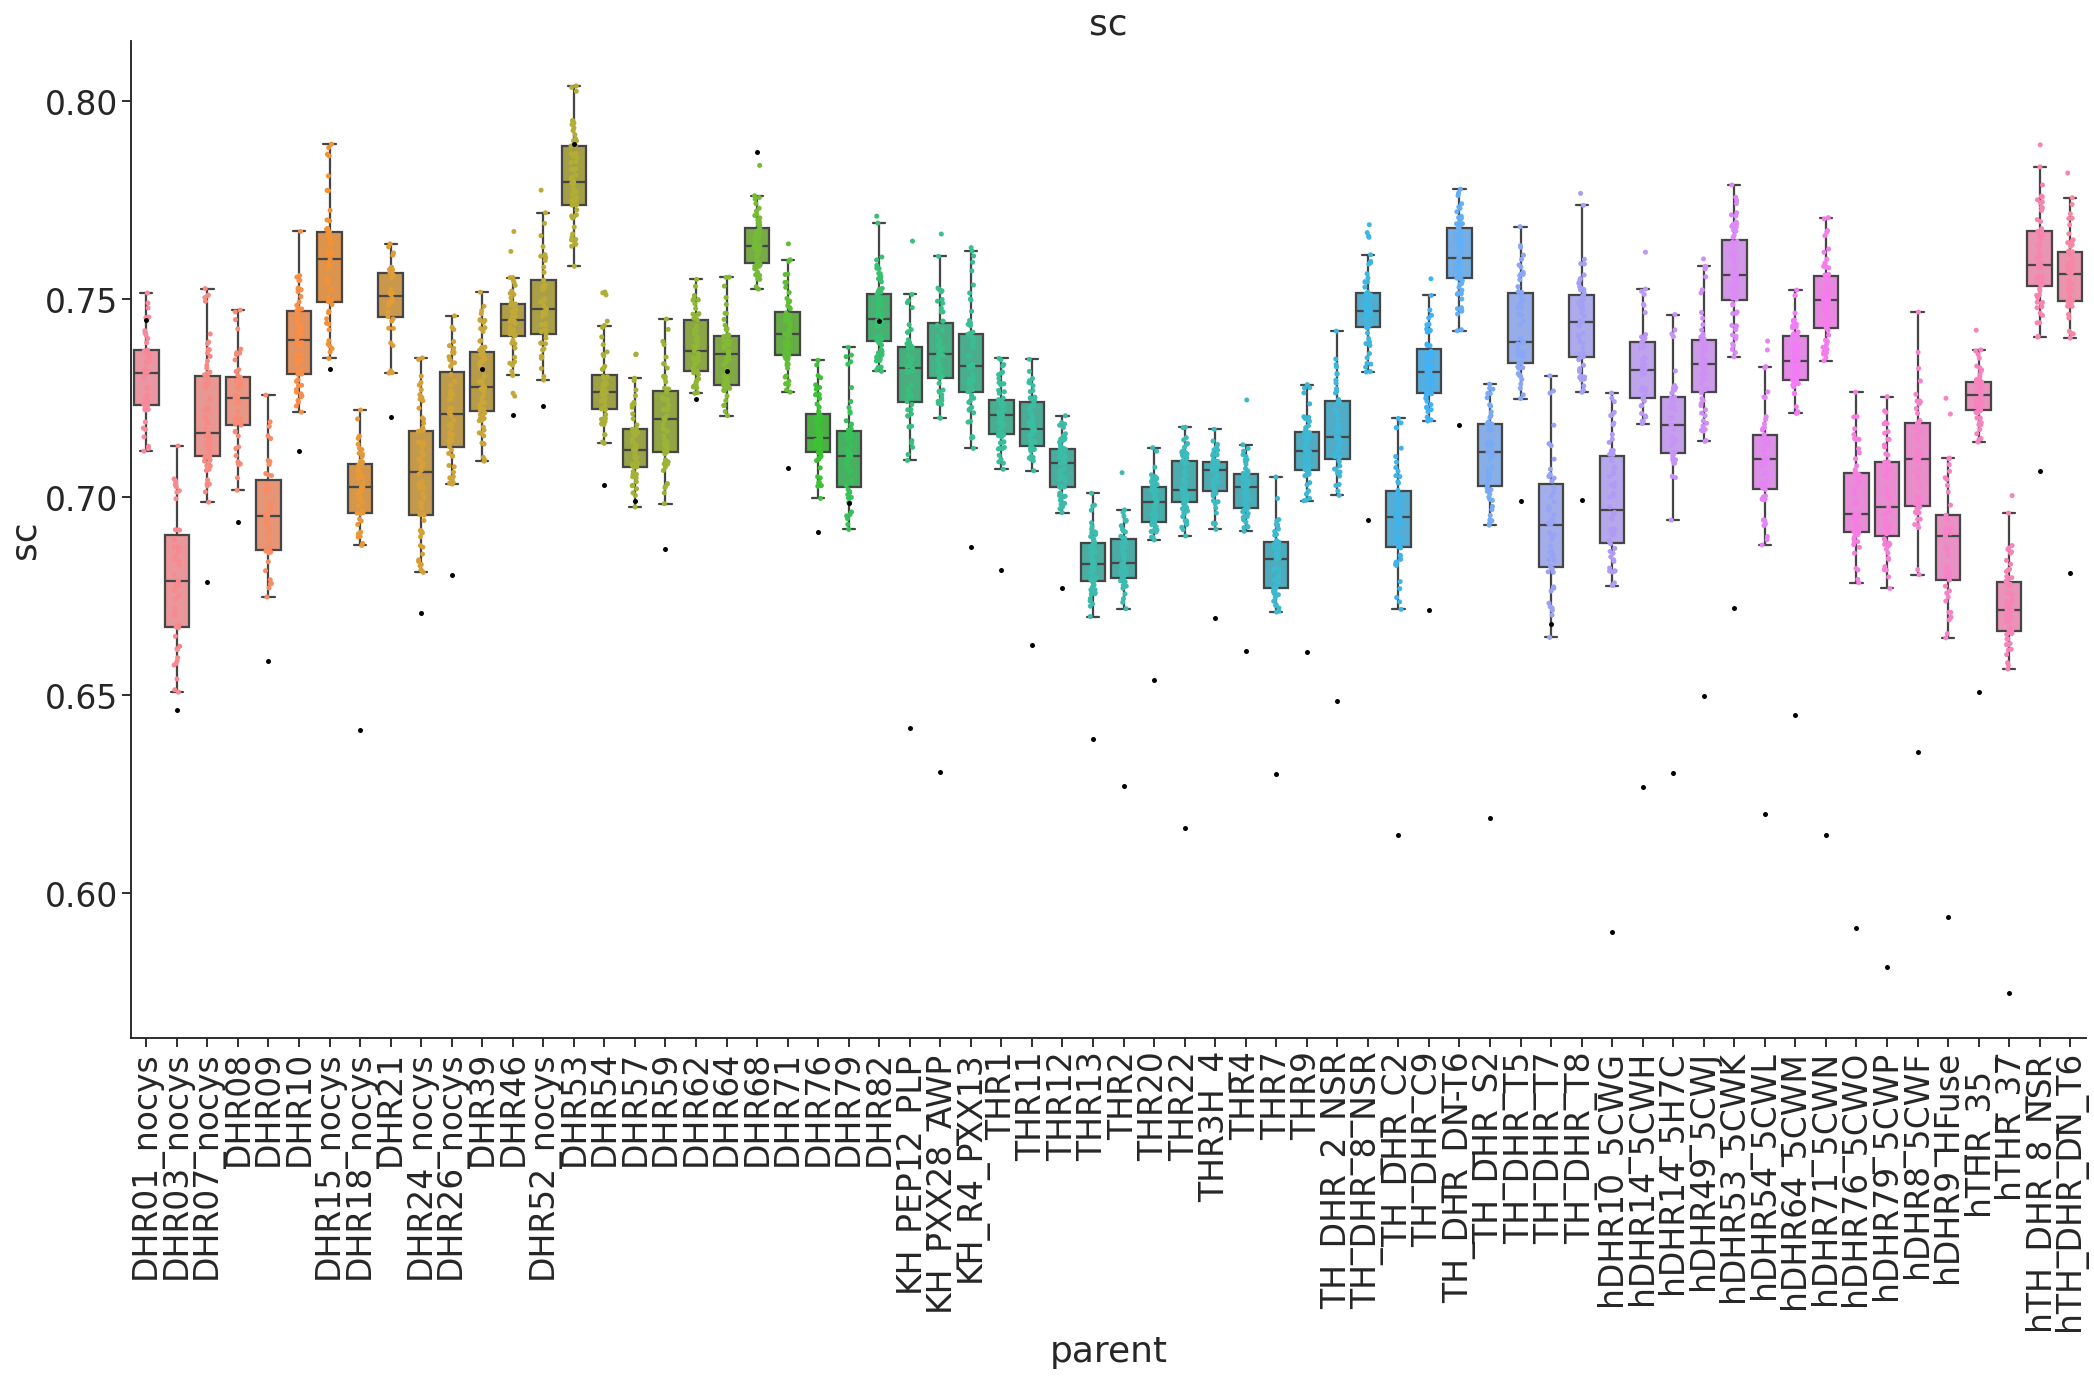

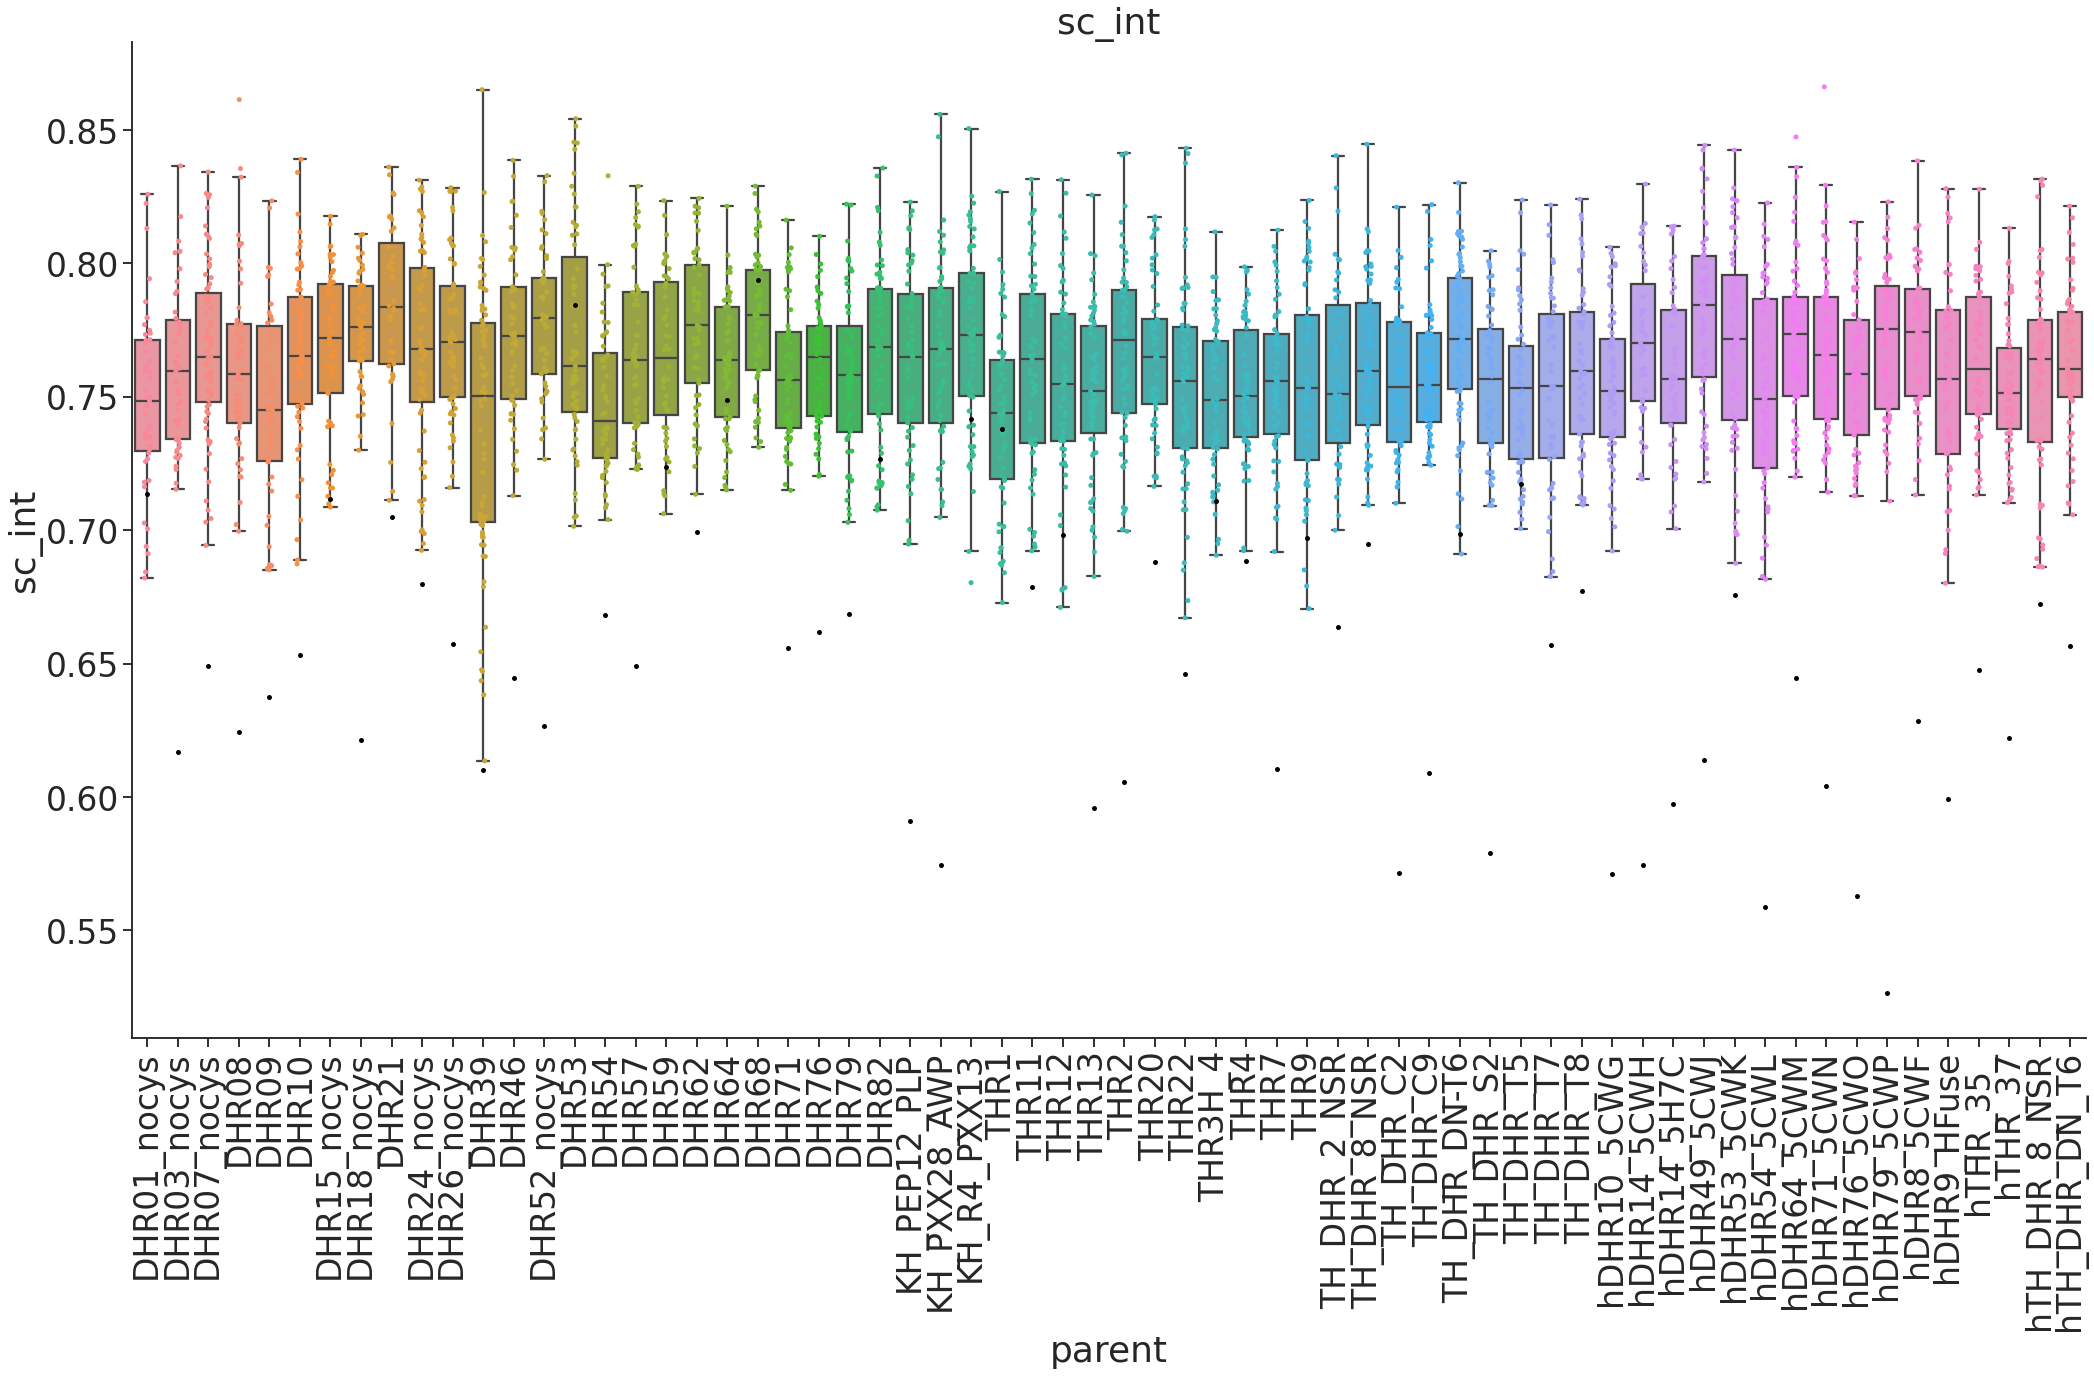

In [16]:
terms = [
    "score_per_res",
    "ddg",
    "interface_buried_sasa",
    "sc",
    "sc_int"
]
order = sorted(list(set(scores_df.parent.values)))
for term in terms:
    fig = plt.figure(figsize=(30,20), tight_layout=True)
    plt.xticks(rotation=90)
    sns.boxplot(
        x="parent", y=term, data=not_bad_df,
        showfliers = False, order=order,
    )
    sns.stripplot(
        x="parent", y=term, data=not_bad_df,order=order,
    )
    sns.swarmplot(
        x="parent", y=term, data=ref_df, color="black",order=order,
    )
    sns.despine()
    plt.title(term)
    plt.show()
    plt.close()
#     fig.savefig("figs/02_after_selection_all_parents_vs_{term}.png".format(term=term))

# Check for class imbalance before and after selection

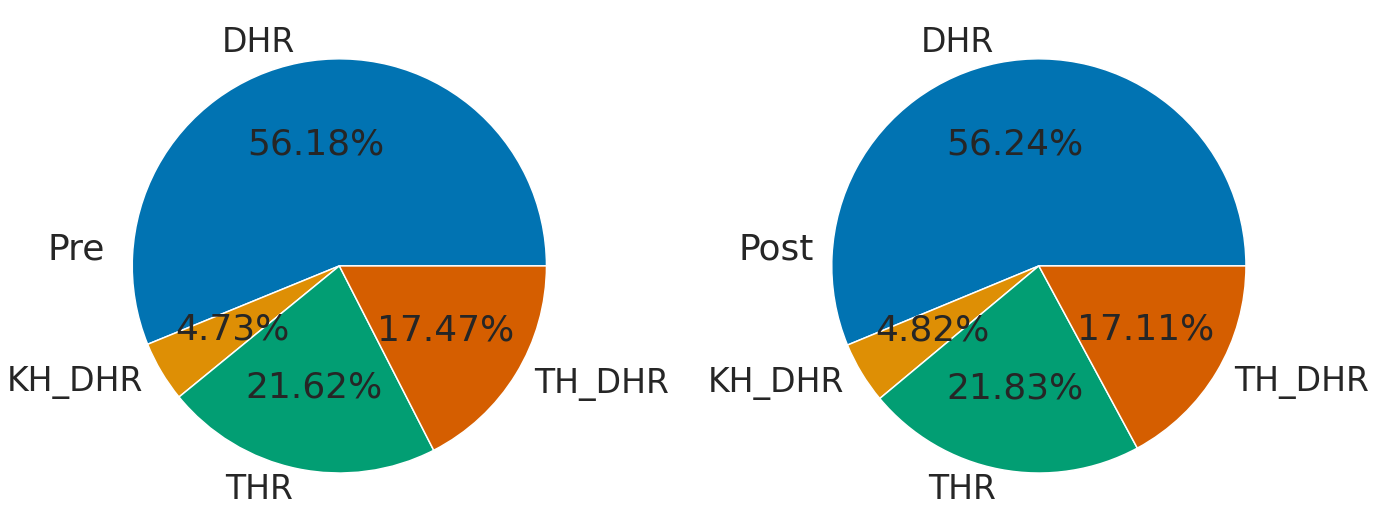

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
not_bad_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax1.set_ylabel("Pre", rotation=0)
ax2.set_ylabel("Post", rotation=0)
plt.tight_layout()
plt.savefig("figs/02_pre_post_selection.png")

# Parallel unzipping, relabeling and packing into a silent of all selected designs
Method maintains score info

In [18]:
import pyrosetta.distributed.io as io
from pyrosetta.distributed.packed_pose.core import PackedPose

def unpack_add_scores_repack(bz2file:str, scores:dict) -> PackedPose:
    import bz2
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    with open(bz2file, "rb") as f:
        ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
    pose = io.to_pose(ppose)
    basename =  os.path.basename(bz2file.replace(".pdb.bz", "", 1))
    pose.pdb_info().name(basename)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    final_ppose = io.to_packed(pose)
    return final_ppose

if not os.getenv("DEBUG"):
    future_pposes = []
    for i, bz2file in enumerate(not_bad_df.index, start=1): # TODO
        # decompress from bz2, add score info and pack
        scores_dict = dict(not_bad_df.loc[bz2file])
        future_ppose = client.submit(unpack_add_scores_repack, bz2file, scores_dict)
        future_pposes.append(future_ppose)
    pposes = []
    for future in tqdm(future_pposes):
        pposes.append(future.result())

out_path = os.path.join(os.getcwd(), "02_silents")
silent_name = "states.silent"

os.makedirs(out_path, exist_ok=True)
io.to_silent(pposes, os.path.join(out_path, silent_name))
msg = """
out_path: {out_path}
packed {i} poses
""".format(out_path=out_path, i=i)
print(msg)

In [19]:
if not os.getenv("DEBUG"):
    future_pposes = []
    for i, bz2file in enumerate(ref_df.index, start=1): # TODO
        # decompress from bz2, add score info and pack
        scores_dict = dict(ref_df.loc[bz2file])
        future_ppose = client.submit(unpack_add_scores_repack, bz2file, scores_dict)
        future_pposes.append(future_ppose)
    pposes = []
    for future in tqdm(future_pposes):
        pposes.append(future.result())

out_path = os.path.join(os.getcwd(), "02_silents")
silent_name = "ref.silent"

os.makedirs(out_path, exist_ok=True)
io.to_silent(pposes, os.path.join(out_path, silent_name))
msg = """
out_path: {out_path}
packed {i} poses
""".format(out_path=out_path, i=i)
print(msg)

100%|██████████| 64/64 [00:25<00:00,  2.51it/s]



out_path: /mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_silents
packed 64 poses



In [20]:
client.close(); cluster.close()